<a href="https://colab.research.google.com/github/ShamScripts/Medicine-Recommendation-System/blob/main/EDA_ModelComparison_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load Dataset

In [18]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
#import pickle
from joblib import dump

In [19]:
import flask
import matplotlib
import joblib
import fuzzywuzzy
import Levenshtein as python_Levenshtein

In [20]:
!pip install joblib

In [21]:
#!pip install Flask==2.2.5 numpy==1.24.4 pandas==1.5.3 scikit-learn==1.2.2 matplotlib==3.7.1 seaborn==0.12.2 joblib==1.3.2 gunicorn fuzzywuzzy python-Levenshtein


In [22]:
import sklearn
print("scikit-learn version:", sklearn.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("numpy version:", np.__version__)
print("Flask version:", flask.__version__)

scikit-learn version: 1.2.2
pandas version: 1.5.3
seaborn version: 0.12.2
numpy version: 1.24.4
Flask version: 2.2.5


In [24]:
# Load the dataset
df = pd.read_csv("kaggle_dataset/Training.csv")

# Step 2: Basic EDA

In [25]:
# Dataset overview
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())

Dataset shape: (4920, 133)

First 5 rows:
    itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0                 0  ...   
4       0           0             0        0                 0  ...   

   blackheads  scurring  skin_peeling  silver_like_dust

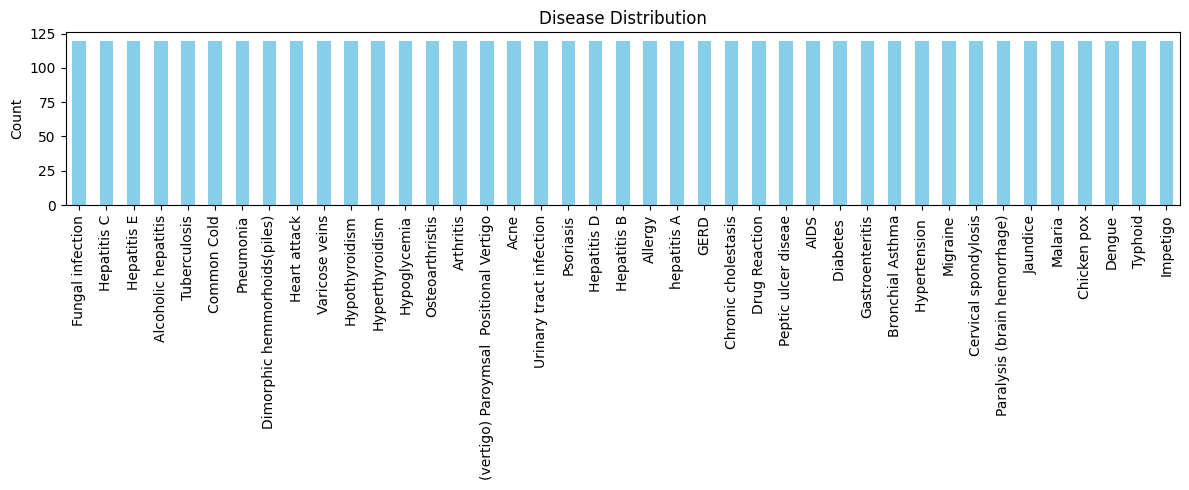

In [26]:
# Count of target labels
plt.figure(figsize=(12, 5))
df['prognosis'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Disease Distribution")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [27]:
# Null check
null_counts = df.isnull().sum()
print("\nMissing values:\n", null_counts[null_counts > 0])


Missing values:
 Series([], dtype: int64)


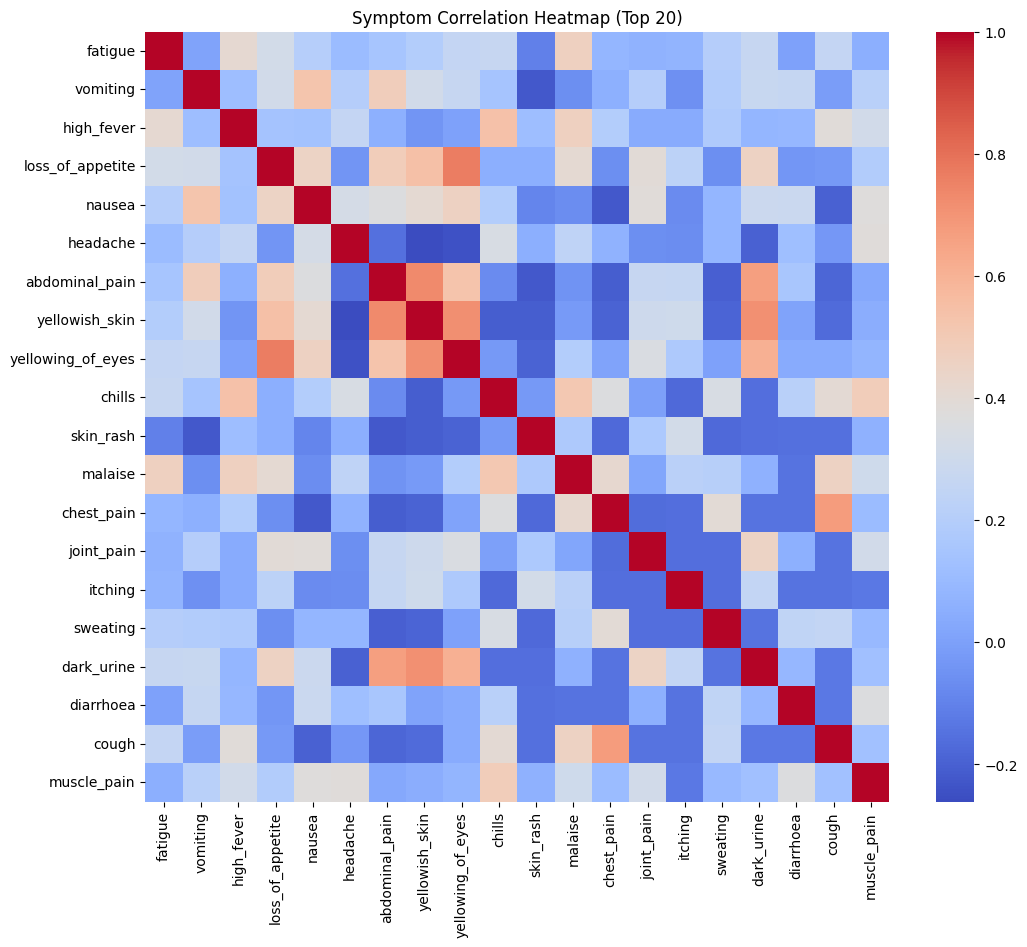

In [28]:
# Symptom variability (top 20)
symptom_variance = df.drop(columns=['prognosis']).var().sort_values(ascending=False)
top_symptoms = symptom_variance.head(20).index

plt.figure(figsize=(12, 10))
sns.heatmap(df[top_symptoms].corr(), cmap='coolwarm', annot=False)
plt.title("Symptom Correlation Heatmap (Top 20)")
plt.show()

# Step 3: Model Comparison

In [29]:
# Features and label
X = df.drop(columns=['prognosis'])
y = df['prognosis']

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Define candidate models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [32]:
# Evaluate each model using cross-validation
print("\nModel Accuracy Comparison (5-Fold CV):")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f} | Std = {scores.std():.4f}")


Model Accuracy Comparison (5-Fold CV):
Logistic Regression: Mean Accuracy = 1.0000 | Std = 0.0000
Support Vector Machine: Mean Accuracy = 1.0000 | Std = 0.0000
Decision Tree: Mean Accuracy = 1.0000 | Std = 0.0000
Random Forest: Mean Accuracy = 1.0000 | Std = 0.0000


# Step 4: Train RandomForest Model

In [33]:
# Train the final model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
print("\nRandom Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Random Forest Evaluation:
Accuracy: 1.0

Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
                            Common Cold   

# Step 5: Cross-Validation

In [35]:
#Cross-Validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())


Random Forest Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation accuracy: 1.0


# Step 6: Feature Importance Visualization

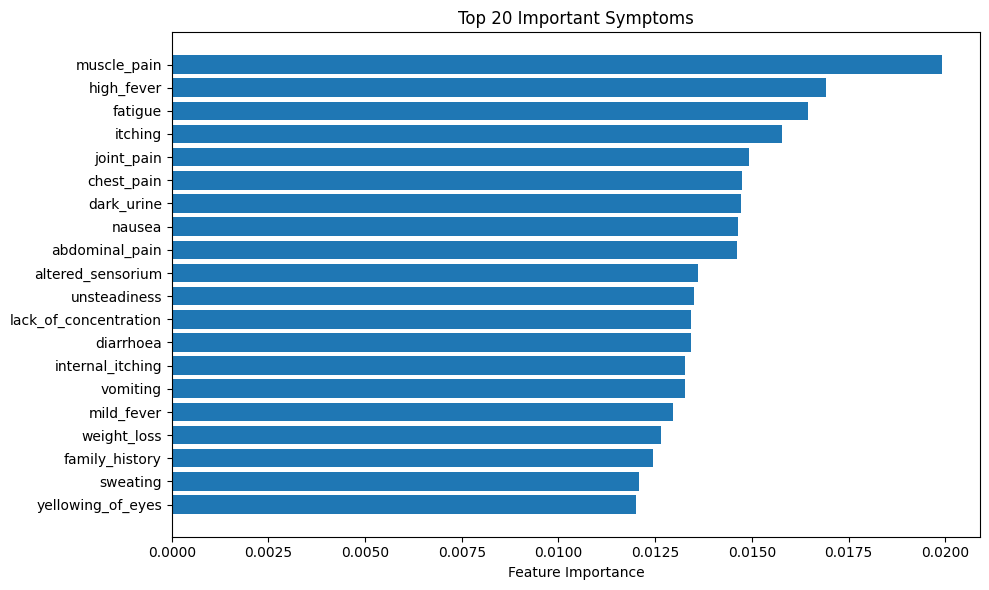

In [36]:
# Feature Importance Visualization
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Symptoms")
plt.tight_layout()
plt.show()


# Step 7: Save Model & Metadata

In [37]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Save model
dump(model, "model/RandomForest.pkl")

['model/RandomForest.pkl']

In [38]:
# Save metadata (optional but useful)
feature_names = X.columns.tolist()
class_names = model.classes_.tolist()

print("\n Model saved as 'RandomForest.pkl'")
print("Total features:", len(feature_names))
print("Total disease classes:", len(class_names))


 Model saved as 'RandomForest.pkl'
Total features: 132
Total disease classes: 41
